In [81]:

%%javascript
nbpresent.mode.tree.set(
    ["app", "theme-manager", "themes", "my-theme"], 
    {
    palette: {
        "my-blue": {
            id: "my-blue",
            rgb: [0, 76, 153]
        },
        "my-white": {
            id: "my-white",
            rgb: [255, 255, 255]
        }
    },
    backgrounds: {
        "my-background": {
            "background-color": "my-white"
        }
    },
    "text-base": {
        "font-family": "Helvetica",
        "font-size": 2.5
    },
    rules: {
        h1: {
            "font-size": 7,
            color: "my-blue"
        }
    }
});

<IPython.core.display.Javascript object>

# Study of Lennard Jones fluid with Monte Carlo simulation

#### Lennard Jones potential
\begin{equation}
V(r)=4\left(\frac{1}{r^{12}}-\frac{1}{r^6}\right)
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.style.use('seaborn')
#mpl.style.use('default')
#import seaborn as sns

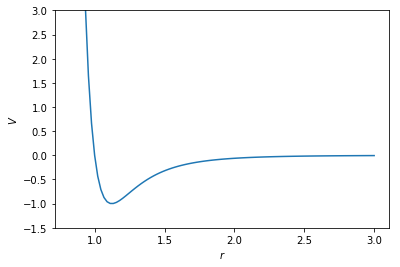

In [2]:
x=np.linspace(0.8,3, 100)[1:]
y=4*(1/x**12-1/x**6)
plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.xlabel('$r$')
plt.ylabel('$V$')
plt.ylim(-1.5, 3)

plt.show()

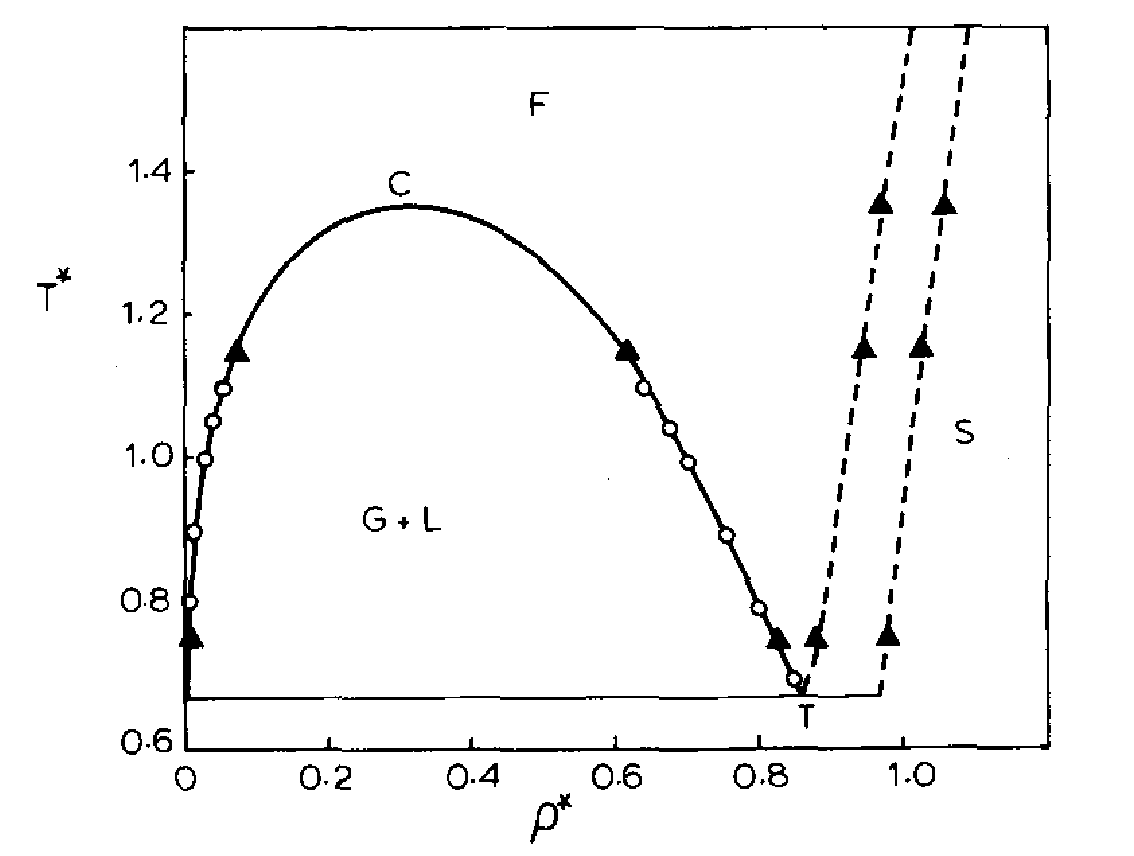

In [3]:
from IPython.display import Image
Image("phasediag2.png", width=400, height=200)

## Outline
* Implementation
* MC simulation
  * Thermalization
  * Error estimate
* From data to thermodynamics
  * Energy and pressure
  * Circumventing the finite size problem: Maxwell construction
  * Phase diagram
* How to improve the results
  * Size scaling

### Implementation

You can find the code on github: https://github.com/suracefm/lennardjonesmc/tree/testing




#### MC simulation (C++)
* Metropolis algorithm, NTV ensemble
* At each step we measure:
  * Energy per particle
  \begin{equation}
  \frac{U}{N}=\sum_{i< j} \frac{4}{N}\left(r_{ij}^{-12}-r_{ij}^{-6}\right)
  \end{equation}
  * Virial coefficient
  \begin{equation}
  B_1=\sum_{i< j} \frac{8}{N}\left(2r_{ij}^{-12}-r_{ij}^{-6}\right)
  \end{equation}
  * Energy per particle square
* Some binning is already performed during the simulation


#### Analysis (Python)
* Tail corrections
  * Energy
  \begin{equation}
  \frac{U^{tail}}{N}=\frac{8\pi}{3}\rho\left(\frac{1}{3r_c^{9}}-\frac{1}{r_c^{3}}\right)
  \end{equation}
  * Virial coefficient
  \begin{equation}
  \frac{B_1^{tail}}{N}=\frac{16\pi}{3}\rho\left(\frac{2}{3r_c^{9}}-\frac{1}{r_c^{3}}\right)
  \end{equation}
  
  \begin{equation}
  P=\rho(T+B_1+B_1^{tail})
  \end{equation}
* Error bars
* Phase diagram


## Utilities

Definition of data type to store simulation data

In [4]:
dt = np.dtype([('BETA', np.float64), ('MCTIME', np.float64), ('VIRIAL1', np.float64), ('DELTA', np.float64),
               ('ENERGY', np.float64), ('N1', np.int32), ('L', np.float64), ('ACCEPTANCE', np.float64),
               ('ENERGYSQUARE', np.float64), ('TEMPERATURE', np.float64), ('DENSITY', np.float64),
               ('PRESSURE', np.float64),('CV', np.float64), ('ENERGYERR', np.float64), ('CVERR', np.float64),
               ('N', np.int32), ('THERMTIME', np.int32), ('THBIN', np.int32), ('BTIME', np.int32),
               ('VOLUME', np.float64), ('PRERR', np.float64), ('ENERGYTAIL', np.float64), ('VIRTAIL', np.float64),
               ('CUTOFF', np.float64), ('U', np.float64), ('TOTENERGY', np.float64), ('DELTAIN', np.float64),
               ('FILENAME', np.unicode_, 32), ('SIMTIME', np.float64), ('CORRTIME', np.float64)])
print(dt.fields.keys())

dict_keys(['VIRTAIL', 'MCTIME', 'TOTENERGY', 'FILENAME', 'ACCEPTANCE', 'CORRTIME', 'VOLUME', 'L', 'CVERR', 'BETA', 'N1', 'BTIME', 'THERMTIME', 'THBIN', 'ENERGYTAIL', 'DELTAIN', 'VIRIAL1', 'PRESSURE', 'ENERGYSQUARE', 'U', 'DELTA', 'TEMPERATURE', 'CV', 'N', 'SIMTIME', 'PRERR', 'ENERGYERR', 'CUTOFF', 'DENSITY', 'ENERGY'])


Functions for input/output

In [5]:
def deltaf(rho, T): # suitable value of trial step 
    delta = 0.12+0.01*T-0.1*rho
    if delta>0.02: return delta
    else: return 0.02

In [6]:
import re
import glob

# Read commented lines of the format '# NAME value' from file .out and return a structured array
def get_data(file):
    d = np.zeros([], dtype=dt)
    with open(file) as f:
        for line in f:
            try:
                m = re.match("# (\S+) ([-+]?\d+.\d+e[+-]?\d+)", line)
                d[m.group(1)]=float(m.group(2))
            except:
                try:
                    m = re.match("# (\S+) ([-+]?\d+.\d+)", line)
                    d[m.group(1)]=float(m.group(2))
                except:
                    try:
                        m = re.match("# (\S+) (\d+)", line)
                        d[m.group(1)]=int(m.group(2))
                    except: pass
    return d    

Functions for binning/error bar analysis

In [7]:
# get s^2 and its error bar (using jackknife) given the array and the binning
def binjk(arra, binning):
    binnum=int(len(arra)/binning)
    red_arr = np.reshape(arra, (binning, binnum), order='F').mean(axis=0)
    jk= (np.sum(red_arr**2)-red_arr**2)/binnum/(binnum-2)-(np.sum(red_arr)-red_arr)**2/binnum/(binnum-1)/(binnum-2)
    return np.mean(jk), np.sqrt(np.var(jk)*(binnum-1))

# get error bar for specific heat using jackknife
def bincvjk(ens, en, binning):
    binnum=int(len(ens)/binning)
    red_en = np.reshape(en, (binning, binnum), order='F').mean(axis=0)
    red_ens = np.reshape(ens, (binning, binnum), order='F').mean(axis=0)
    cvjk = (np.sum(red_ens)-red_ens)/(binnum-1)+(np.sum(red_en**2)-red_en**2)/(binnum*(binnum-1)*(binnum-2))\
    -(np.sum(red_en)-red_en)**2/(binnum*(binnum-2))
    return np.var(cvjk)*(binnum-1)

npbintec=np.vectorize(binjk, signature='(n),()->(),()')
npbincvjk=np.vectorize(bincvjk, signature='(n),(n),()->()')

In [8]:
# get saturation value of a curve, with weighted average

seqlen=12 # number of consecutive points to test constant fit
exclen=3 # number of initial points to exclude from the average

def get_satval(values, errors):
    chisq=100
    i=-1
    weights=1/errors**2
    while chisq>seqlen-1: 
        if i>len(values)-seqlen: return np.nan, np.nan, np.nan
        else:
            i+=1
            avg=np.average(values[i:i+seqlen], weights=weights[i:i+seqlen])
            chisq=np.sum((values[i:i+seqlen]-avg)**2*weights[i:i+seqlen])
    avg=np.average(values[i+exclen:i+seqlen], weights=weights[i+exclen:i+seqlen], returned=True)
    return avg[0], 1/np.sqrt(avg[1]), i        

In [9]:
# read file .out, get error bars using binning technique + jackknife and 
# return all data collected in a variable of type dt

def get_mcdata(file):
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['THBIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, ensqbin, virbin =np.transpose(arr[indmax:])
    d['ENERGY'] = np.mean(energybin)
    d['VIRIAL1'] = np.mean(virbin)
    d['ENERGYSQUARE'] = np.mean(ensqbin)
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    d['FILENAME']=file
    
    bins = np.array([i for i in range(1,70) if int(d['MCTIME']/d['BTIME'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(virbin, bins)
    reses=npbintec(ensqbin, bins)
    rescv=npbincvjk(ensqbin, energybin, bins)
    
    s_en=get_satval(resen[0], resen[1])
    d['ENERGYERR']=np.sqrt(s_en[0])

    s_pr=get_satval(respr[0], respr[1])
    d['PRERR']=np.sqrt(s_pr[0])
    
    if not np.isnan(s_en[2]):
        i=int(s_en[2])
        vec=rescv[i+exclen : i+seqlen]
        d['CVERR']=d['BETA']**2*np.sqrt(np.average(rescv[i+exclen : i+seqlen], \
               weights=1/(resen[1][i+exclen:i+seqlen])**2))
    else: d['CVERR']=np.nan
    d['CORRTIME']=d['ENERGYERR']**2*d['MCTIME']*d['BETA']**2/d['CV']
    return d

Functions for Maxwell construction

In [71]:
#from scipy.integrate import simps

def trap_area(x, y, ysec=None):
    #return simps(y, x, even='last')
    if ysec is None: return np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2)
    else:
        dA=np.maximum(ysec[1:], ysec[:-1])*np.diff(x)**3/12
        return np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2), np.sum(dA**2)
        #Atrap=np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2)
        #xex=np.concatenate(([x[0]], x, [x[-1]]))
        #xm=(xex[2:]-xex[0:-2])/2
        #Arect=np.sum(xm*y)
        #Asimps=simps(y, x, even='last')
        #Areas=np.array([Arect, Atrap, Asimps])
        #return np.mean(Areas), np.var(Areas)


def maxwell_func(Parr, Varr, P, T, Perr=0, P0err=0):
    index=np.argmax(Parr<P)
    V0=(Varr[index-1]-Varr[index])*(P-Parr[index])/(Parr[index-1]-Parr[index])+Varr[index]
    if Parr[-1]<P:
        rind=np.where(Parr>P)[0][-1]
        Vlast=(Varr[rind+1]-Varr[rind])*(P-Parr[rind])/(Parr[rind+1]-Parr[rind])+Varr[rind]
        newP=np.append(P, np.append(Parr[index:rind+1], P))
        newV=np.append(V0, np.append(Varr[index:rind+1], Vlast))
        if len(newP>1) and index>0:
            Psec=np.abs(((Parr[index+1:rind+2]-Parr[index:rind+1])/(Varr[index+1:rind+2]-Varr[index:rind+1])-
                  (Parr[index:rind+1]-Parr[index-1:rind])/(Varr[index:rind+1]-Varr[index-1:rind]))*2/
                        (Varr[index+1:rind+2]-Varr[index-1:rind]))
            Psec=np.concatenate(([0],Psec,[0]))

            newPerr=np.zeros((len(newP)+2))
            dAdP=np.zeros((len(newP)+2))
            dAdP[0]+=(P+Parr[index])*(V0-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[1]+=-(P+Parr[index])*(Varr[index-1]-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[2]+=-(P+Parr[index])*(V0-Varr[index-1])/2/(Parr[index-1]-Parr[index])
            dAdP[-1]+=(P+Parr[rind])*(Vlast-Varr[rind])/2/(Parr[rind+1]-Parr[rind])
            dAdP[-2]+=-(P+Parr[rind])*(Varr[rind+1]-Varr[rind])/2/(Parr[rind+1]-Parr[rind])
            dAdP[-3]+=-(P+Parr[rind])*(Vlast-Varr[rind+1])/2/(Parr[rind+1]-Parr[rind])
            dAdP[1:-2]+=(newV[1:]-newV[:-1])/2
            dAdP[2:-1]+=(newV[1:]-newV[:-1])/2
            newPerr[0]=Perr[index-1]
            newPerr[-1]=Perr[rind+1]
            newPerr[1]=P0err
            newPerr[-2]=P0err
            newPerr[2:-2]=Perr[index:rind+1]
            A, varA=trap_area(newV, newP-P, Psec)
            dA= np.sqrt(np.sum((dAdP*newPerr)**2)+varA)
        else:
            A = trap_area(newV, newP-P)
            dA=np.nan

        
        return A, V0, Vlast, dA
    else:
        newP=np.append(P, Parr[index:])
        newV=np.append(V0, Varr[index:])
        
        if len(newP)>1 and index>0:
            Psec=np.abs(((Parr[index+1:]-Parr[index:-1])/(Varr[index+1:]-Varr[index:-1])-
                  (Parr[index:-1]-Parr[index-1:-2])/(Varr[index:-1]-Varr[index-1:-2]))*2/
                        (Varr[index+1:]-Varr[index-1:-2]))
            Psec=np.concatenate(([0],Psec,[0]))

            newPerr=np.zeros((len(newP)+1))
            dAdP=np.zeros((len(newP)+1))
            dAdP[0]+=(P+Parr[index])*(V0-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[1]+=-(P+Parr[index])*(Varr[index-1]-Varr[index])/2/(Parr[index-1]-Parr[index])
            dAdP[2]+=-(P+Parr[index])*(V0-Varr[index-1])/2/(Parr[index-1]-Parr[index])
            dAdP[1:-1]+=(newV[1:]-newV[:-1])/2
            dAdP[2:]+=(newV[1:]-newV[:-1])/2
            newPerr[0]=Perr[index-1]
            newPerr[1]=P0err
            newPerr[2:]=Perr[index:]
            A, varA=trap_area(newV, newP-P, Psec)
            dA=np.sqrt(np.sum((dAdP*newPerr)**2)+varA)
        else:
            A = trap_area(newV, newP-P)
            dA=np.nan
        
        return A+T*np.log(T/P/Varr[-1])-T+P*Varr[-1], V0, T/P, dA

def maxwell_construction(P, V, T, Perr=0, P0err=0.00001):
    Pmax=np.amax(P)
    Pmin=max(np.amin(P),0)
    Pfl=np.flip(P,0)
    Vfl=np.flip(V,0)
    Amax=0
    Amin=0
    Vmax=[0,0]
    Vmin=[0,0]
    while Pmax-Pmin>0.000001:
        Ptest=(Pmax+Pmin)/2
        res=maxwell_func(Pfl, Vfl, Ptest, T, Perr=Perr, P0err=0.00001)
        if res[0]>0:
            Pmin=Ptest
            Amax=res[0]
            Vmax=[res[1], res[2]]
        else:
            Pmax=Ptest
            Amin=res[0]
            Vmin=[res[1], res[2]]
    dP=res[3]*np.abs((Pmax-Pmin)/(Amax-Amin))
    dVl=dP*np.abs((Vmax[0]-Vmin[0])/(Pmax-Pmin))
    dVr=dP*np.abs((Vmax[1]-Vmin[1])/(Pmax-Pmin))
    return Ptest, res[1], res[2], dP, dVl, dVr
    

## The simulation: equilibration time

Initial configuration: 125 particles in a simple cubic lattice

In [ ]:
## file = './data/first/test1.out'#, './data/phasediag2/test0085.out'
simdata = get_mcdata(file)

arr=np.genfromtxt(file, usemask=True, delimiter='\t')
indmax=int(2*simdata['THERMTIME']/simdata['THBIN'])
energyth, virth, rhokth = np.transpose(arr[:indmax])
energybin, ensqbin, virbin =np.transpose(arr[indmax:])

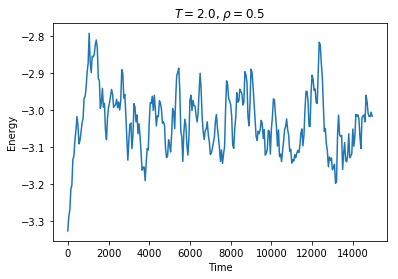

In [12]:
f, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(simdata['THBIN']*np.arange(len(rhokth)),energyth)
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.set_title(r'$T=$%.1f, $\rho=$%.1f' %(simdata['TEMPERATURE'], simdata['DENSITY']))

plt.show()

In [13]:
file_2 = './data/phasediag2/test0085.out'
simdata_2 = get_mcdata(file_2)

arr_2=np.genfromtxt(file_2, usemask=True, delimiter='\t')
indmax_2=int(2*simdata_2['THERMTIME']/simdata_2['THBIN'])
energyth, virth, rhokth = np.transpose(arr_2[:indmax_2])

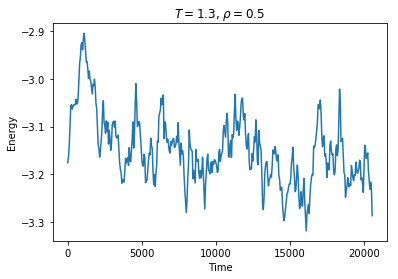

In [14]:
f, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(simdata_2['THBIN']*np.arange(len(rhokth)),energyth)
ax.set_xlabel('Time')
ax.set_ylabel('Energy')
ax.set_title(r'$T=$%.1f, $\rho=$%.1f' %(simdata_2['TEMPERATURE'], simdata_2['DENSITY']))

plt.show()

Is there a better way to track the "melting" of the lattice?

\begin{equation}
\rho(\mathbf{k})= \frac{1}{N} \sum_{i=1}^N \cos \mathbf{k}\cdot \mathbf{r_i}
\end{equation}

where $\mathbf{k}$ is chosen such to have the periodicity of the lattice

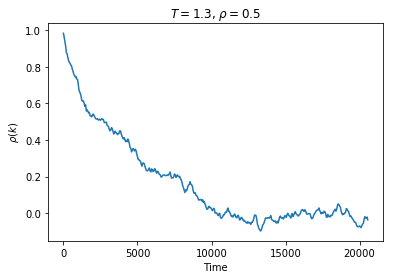

In [15]:
f, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(simdata_2['THBIN']*np.arange(len(rhokth)),rhokth)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\rho(k)$')
ax.set_title(r'$T=$%.1f, $\rho=$%.1f' %(simdata_2['TEMPERATURE'], simdata_2['DENSITY']))

plt.show()

### Error bars
#### Block technique for sample averages

Block technique: we divide the simulation (total number of steps $N_{steps}$) into $k$ blocks of length $t_B$ ($N_{steps}=k \cdot t_B$). We compute the average quantity over each bin $x_{B_i}$. The sample average of $\{x_{B_i}\}$ is $\bar{x}$, so, if the binned quantities are independent variables, the following is an estimator of the variance of $\bar{x}$

$x_{B_i}=$ average quantity over each bin 

$k=$ number of bins

$t_b=$ size of bin


\begin{equation}
s^2=\frac{1}{k(k-1)}\sum_{j=1}^k (x_{B_j}-\bar{x})^2.
\end{equation}

We change $k$ keeping $N=k\cdot t_b$ fixed.

When the $t_b \gg \tau_{corr} \Longrightarrow s^2 \rightarrow \sigma^2_{\bar{x}}$.

In [16]:
bins = np.array([i for i in range(1,60) if int(simdata['MCTIME']/simdata['BTIME'])%i==0])
resen=npbintec(energybin, bins)
respr=npbintec(virbin, bins)
reses=npbintec(ensqbin, bins)
rescv=npbincvjk(ensqbin, energybin, bins)
  
s_en=get_satval(resen[0], resen[1])
saten=s_en[0]

s_pr=get_satval(respr[0], respr[1])
satpr=s_pr[0]

i=int(s_en[2])
vec=rescv[i+exclen : i+seqlen]
satcv=simdata['BETA']**4*(np.average(rescv[i+exclen : i+seqlen], \
           weights=1/(resen[1][i+exclen:i+seqlen])**2))

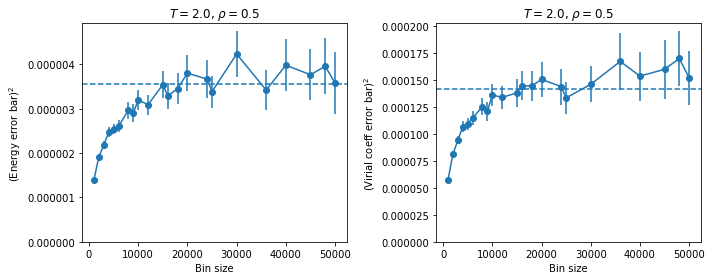

In [17]:
f, axarr = plt.subplots(1,2,figsize=(10,4))

axarr[0].errorbar(bins*simdata['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[0].axhline(y=saten, color='C0', linestyle='dashed')
axarr[1].errorbar(bins*simdata['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[1].axhline(y=satpr, color='C0', linestyle='dashed')
#axarr[2].plot(bins*simdata['BTIME'], simdata['BETA']**4*rescv, marker='o', label = r'$\beta=$%.2f' % simdata['BETA'])
#axarr[2].axhline(y=satcv, color='C0', linestyle='dashed')

axarr[0].set_ylabel(r'(Energy error bar$)^2$')
axarr[1].set_ylabel(r'(Virial coeff error bar$)^2$')
#axarr[2].set_ylabel(r'(Specific heat error bar$)^2$')

for ax in axarr:
    ax.set_xlabel('Bin size')
    ax.set_ylim(ymin=0)
    ax.set_title(r'$T=$%.1f, $\rho=$%.1f' %(simdata['TEMPERATURE'], simdata['DENSITY']))

plt.tight_layout()
plt.show()

They saturate to a constant value, with some fluctuations.

#### Jackknife estimate of error bars for $s^2$
We apply jackknife technique to calculate the error bars for $s^2$, under the assumption that the bins are large enough to be independent.

\begin{equation}
{s^2_i}^J=\frac{1}{(k-1)(k-2)}\sum_{j=1, j\neq i}^k (x_j-\bar{x}_i^J)^2.
\end{equation}

\begin{equation}
\frac{1}{k}\sum_{i=1}^k {s^2_i}^J=\frac{k}{k-1} s^2
\end{equation}

We construct an unbiased estimator

\begin{equation}
{s^2_i}^J=\frac{1}{k(k-2)}\sum_{j=1, j\neq i}^k (x_j-\bar{x}_i^J)^2.
\end{equation}

The unbiased jackknife estimator is obtained as
\begin{equation}
\theta_i^J=\frac{k\bar{x^2}-x_i^2}{k(k-2)}-\frac{(k\bar{x}-x_i)^2}{k(k-1)(k-2)}
\end{equation}

with average

\begin{equation}
\bar{\theta^J}=\frac{1}{k}\sum_i \theta_i^J =\frac{1}{k-1}(\bar{x^2}-\bar{x}^2)=s^2.
\end{equation}

The error according to jackknife technique is given by
\begin{equation}
\delta \theta^2 ={\frac{k-1}{k}\sum_i (\theta_i^J-\bar{\theta^J})^2}
\end{equation}

### Block technique and jackknife for specific heat

$g_i =$ average of $E$ over bin $i$ 

$f_i =$ average of $E^2$ over bin $i$

** The square of the energy has to be performed before averaging **

The specific heat is proportional to
\begin{equation}
C=\bar{E^2}-\bar{E}^2=\bar{f}-\left(\bar{g}\right)^2 %=\frac{1}{k}\sum_{i=1}^k f_i-\left(\frac{1}{k}\sum_{i=1}^k g_i\right)^2
\end{equation}

\begin{equation}
C_i^J = \bar{f}_i^J-\left(\bar{g}_i^J\right)^2
\end{equation}

Ths estimator is biased. We define the unbiased version of the Jackknife estimator

\begin{equation}
C_i^J = \bar{f}_i^J-\frac{(k-1)^2}{k(k-2)}\left(\bar{g}_i^J\right)^2+\frac{1}{k(k-2)}{\bar{g^2}_i}^J
\end{equation}

\begin{equation}
C_i^J=\frac{k\bar{f}-f_i}{k-1}+\frac{k\bar{g^2}-g_i^2}{k(k-1)(k-2)}-\frac{(k\bar{g}-g_i)^2}{k(k-2)}.
\end{equation}


It has the property that
\begin{equation}
\frac{1}{k}\sum_{i=1}^k C_i^j =\bar{C^j}=C
\end{equation}


This means that we have been able to write our estimator as the sample average of the $C_i^j$, which are independent variables if the bins are large enough. The variance of $C$ can be estimated using Jackknife technique

\begin{equation}
\delta C =\sqrt{\frac{1}{k-1}\sum_{i=1}^k (C_i^J-C)^2}
\end{equation}

We plot this value for different size of the bins until we reach convergence (size much larger than correlation time).

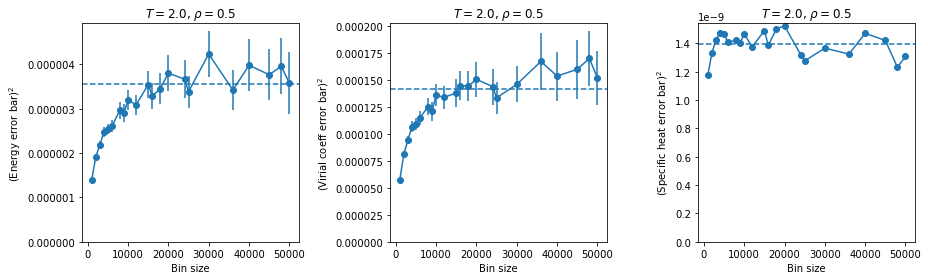

In [18]:
f, axarr = plt.subplots(1,3,figsize=(13,4))

axarr[0].errorbar(bins*simdata['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[0].axhline(y=saten, color='C0', linestyle='dashed')
axarr[1].errorbar(bins*simdata['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[1].axhline(y=satpr, color='C0', linestyle='dashed')
axarr[2].plot(bins*simdata['BTIME'], simdata['BETA']**4*rescv, marker='o', label = r'$\beta=$%.2f' % simdata['BETA'])
axarr[2].axhline(y=satcv, color='C0', linestyle='dashed')

axarr[0].set_ylabel(r'(Energy error bar$)^2$')
axarr[1].set_ylabel(r'(Virial coeff error bar$)^2$')
axarr[2].set_ylabel(r'(Specific heat error bar$)^2$')

for ax in axarr:
    ax.set_xlabel('Bin size')
    ax.set_ylim(ymin=0)
    ax.set_title(r'$T=$%.1f, $\rho=$%.1f' %(simdata['TEMPERATURE'], simdata['DENSITY']))
    
plt.tight_layout()
plt.show()

## Results

In [19]:
dsnt=np.empty(0, dtype=dt)


for file in np.sort(glob.glob('./data/nicolas_test/*.out'))[:18]:
    d=get_mcdata(file)
    dsnt=np.append(dsnt, d)


In [20]:
nt=dsnt.view().reshape((3,6))
nictab=np.loadtxt('./nicolastab.dat', unpack=True)

In [21]:
print(nictab[:,:6])

[[ 0.35  0.35  0.35  0.35  0.35  0.35]
 [ 2.99  2.5   1.97  1.7   1.45  1.2 ]
 [-2.03 -2.1  -2.22 -2.27 -2.37 -2.44]
 [ 1.23  0.9   0.56  0.39  0.2   0.02]]


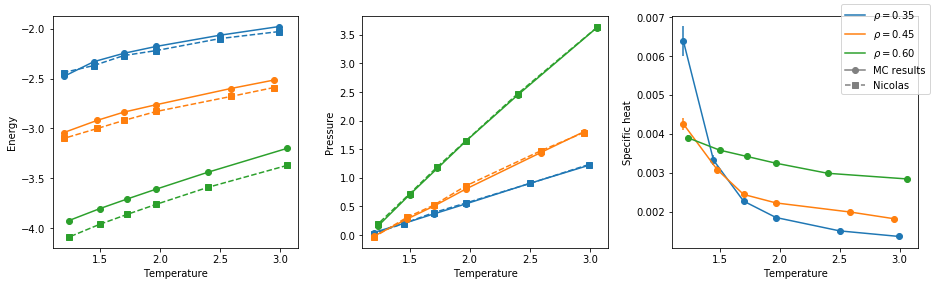

In [66]:
f, axarr = plt.subplots(1,3,figsize=(13,4))
sym=[]

for i in range(3):
    rho=nt[i, 0]['DENSITY']
    color='C%d' %i
    sym.append(plt.Line2D((0,1),(0,0), color=color))
    axarr[0].errorbar(nt[i, :]['TEMPERATURE'], nt[i, :]['ENERGY'], 
                            yerr=nt[i, :]['ENERGYERR'],marker='o', label= r'$\rho=$%.2f' % rho, color=color)
    axarr[0].plot(nictab[1,6*i:6*i+6], nictab[2,6*i:6*i+6], marker='s', color=color, linestyle='dashed')
    
    axarr[1].errorbar(nt[i, :]['TEMPERATURE'], nt[i, :]['PRESSURE'], 
                            yerr=nt[i, :]['PRERR'],marker='o', label= r'$\rho=$%.2f' % rho, color=color)
    axarr[1].plot(nictab[1,6*i:6*i+6], nictab[3,6*i:6*i+6], marker='s', color=color, linestyle='dashed')
    
    axarr[2].errorbar(nt[i, :]['TEMPERATURE'], nt[i, :]['CV'], 
                            yerr=nt[i, :]['CVERR'],marker='o', label= r'$\rho=$%.2f' % rho, color=color)

axarr[0].set_ylabel("Energy")
axarr[1].set_ylabel("Pressure")
axarr[2].set_ylabel("Specific heat")
for ax in axarr: ax.set_xlabel('Temperature')


handles, labels = axarr[1].get_legend_handles_labels()
sym.append(plt.Line2D((0,1),(0,0), color='gray', marker='o'))
sym.append(plt.Line2D((0,1),(0,0), color='gray', marker='s', linestyle='dashed'))
legend=f.legend(sym, list(labels)+['MC results', 'Nicolas'], 'upper right')

plt.tight_layout()
plt.show()

Nicolas, J. J., et al. "Equation of state for the Lennard-Jones fluid." *Molecular Physics* 37.5 (1979): 1429-1454.

## Phase diagram

In [23]:
## read files and create datasets

# dataset1=np.empty(0, dtype=dt)

# for file in np.roll(np.sort(glob.glob('./data/phasediag2/*.out')),16):
#     d=get_mcdata(file)
#     dataset1=np.append(dataset1, d)

# dataset2=np.empty(0, dtype=dt)

# for file in np.roll(np.sort(glob.glob('./data/phasediag3/*.out')),16):
#     d=get_mcdata(file)
#     dataset2=np.append(dataset2, d)
    
# datasets=[dataset1, dataset2]

In [24]:
## write datasets to files

# fileres = open('./data/phasediag2/resnew.dat','w') 
# fileres.write('# ')
# for name in dt.names: fileres.write(name+' ') 
# fileres.write('\n')
# for index, i in enumerate(dataset1):
#     for j in i:
#         fileres.write(str(j)+' ')
#     fileres.write('\n')   
# fileres.close()

# fileres = open('./data/phasediag3/resnew.dat','w') 
# fileres.write('# ')
# for name in dt.names: fileres.write(name+' ') 
# fileres.write('\n')
# for index, i in enumerate(dataset2):
#     for j in i:
#         fileres.write(str(j)+' ')
#     fileres.write('\n')   
# fileres.close()

In [25]:
# read datasets from files
ds1=np.genfromtxt('./data/phasediag2/resnew.dat', dtype=dt, names=True)
ds2=np.genfromtxt('./data/phasediag3/resnew.dat', dtype=dt, names=True)
#print(ds1['THERMTIME'])
#print(ds2['THERMTIME'])

In [26]:
myds1=ds1.view().reshape((19,8))
myds2=ds2.view().reshape((19,8))
mydsn=np.concatenate((myds1, myds2), axis=0)
myds=mydsn.reshape((19,16), order='F')

In [27]:
phaseseplist=[]
tottime=0


# do Maxwell construction    

for i in range(16): 
    T=myds[0, i]['TEMPERATURE']
    P0,Vl,Vr, dP0, dVl, dVr =maxwell_construction(myds[:, i]['PRESSURE'][2:],
                                                  1/myds[:, i]['DENSITY'][2:], T, Perr=myds[:, i]['PRERR'][2:])
    phaseseplist.append(np.array([T, P0, 1/Vr, 1/Vl, dP0, dVr/Vr**2, dVl/Vl**2]))
#count total number of simulation steps
tottime+=np.sum(myds[:,:]['MCTIME'])+np.sum(myds[:,:]['THERMTIME'])
phasesep=np.array(phaseseplist)


/home/federica/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:103: RuntimeWarning: divide by zero encountered in double_scalars


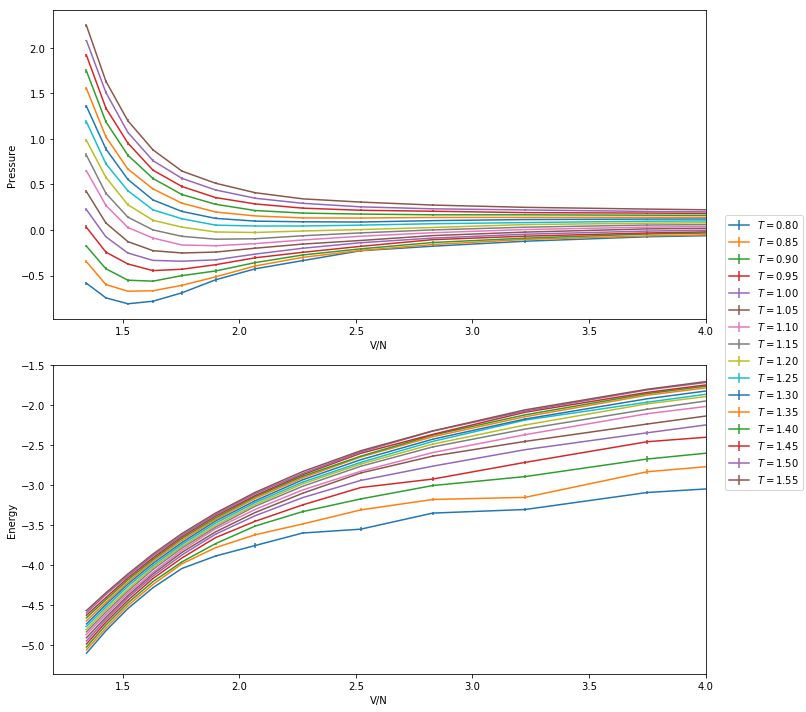

In [70]:
#Plot
fpv, axarrpv = plt.subplots(2,1,figsize=(10,10))

# for dataset in [ds1,ds2]:
#     myds=dataset.view().reshape((19,8))
   
for i in range(16):
    T=myds[0, i]['TEMPERATURE']
    axarrpv[0].errorbar(1/myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'], 
                        yerr=myds[:, i]['PRERR'], label= r'$T=$%.2f' % T)
    axarrpv[1].errorbar(1/myds[:, i]['DENSITY'], myds[:,i]['ENERGY'],
                        yerr=myds[:, i]['ENERGYERR'], label= r'$T=$%.2f' % T)
    
for ax in axarrpv:
    #ax.legend()
    ax.set_xlim(xmin=1.2, xmax=4)
    ax.set_xlabel("V/N")
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fpv.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
axarrpv[0].set_ylabel("Pressure")
axarrpv[1].set_ylabel("Energy")
axarrpv[1].set_ylim(ymax=-1.5)
plt.tight_layout()

plt.show()

We find negative values for the pressure. What does it mean?



\begin{equation}
P=-\left.\frac{\partial F}{\partial V}\right|_T
\end{equation}

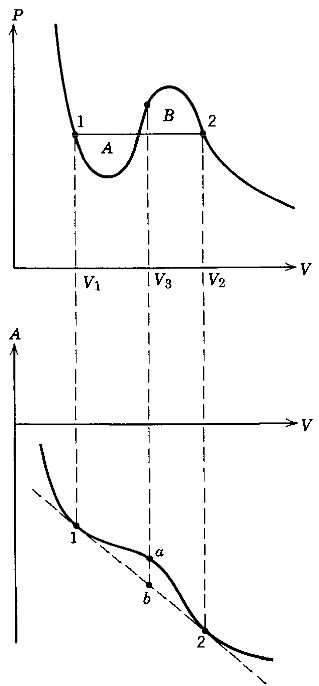

In [29]:
Image("maxwell.png", width=300)

Consider a volume $V_3=xV_1+(1-x)V_2$ with $x\in [0,1]$

\begin{equation}
f(v_3)>xf(v_1)+(1-x)f(v_2)
\end{equation}

The homogeneous phase with inverse density $v_3$ is less energetically favourable than a mixture of
* a fraction $x$ of particles in a phase with inverse density $v_1$
* a fraction $1-x$ of particles in a phase with inverse density $v_2$
When kept at fixed temperature, the system goes from point 1 to point 2 by changing the ratio of liquid to vapour, keeping $P$ constant.

**This is not what we see! Why?**

There is a free energy penalty to pay for forming an interface between two phases.

This energy scales with the area of the system, not with the volume. So it is negligible in the thermodynamic limit.

Since our system has small size, the homogeneous phase is still the one energetically favourable.

We can use thermodynamics to find the properties of the cohexistence phase.

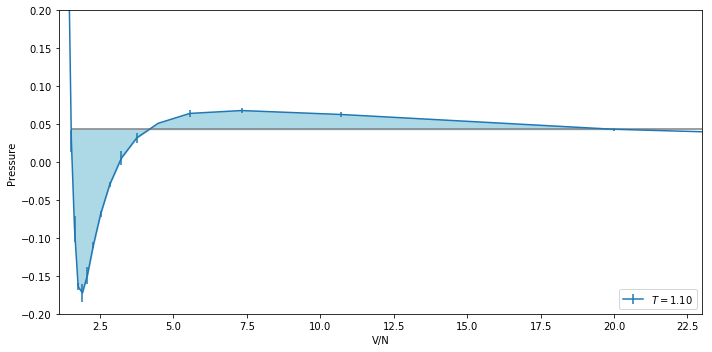

In [30]:
# Plot Maxwell construction

fmc, axmc = plt.subplots(1,1,figsize=(10,5))

i=6
T=myds[0, i]['TEMPERATURE']
axmc.errorbar(1/myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'],
              yerr=myds[:, i]['PRERR'], label= r'$T=$%.2f' % T)


        
P0,Vl,Vr, dP0, dVl, dVr =maxwell_construction(myds[:, i]['PRESSURE'][2:], 1/myds[:, i]['DENSITY'][2:],
                                              T, Perr=myds[:, i]['PRERR'][2:])
mask=np.argwhere((1/myds[:, i]['DENSITY']>Vl) & (1/myds[:, i]['DENSITY']<Vr))
Vma = 1/myds[:, i]['DENSITY'][mask][:,0]
Pma =myds[:, i]['PRESSURE'][mask][:,0]
axmc.fill_between(Vma, Pma, P0, color='lightblue')


axmc.legend(loc='lower right')
axmc.set_xlim(xmin=1.1, xmax=23)
axmc.set_ylim(ymin=-0.2, ymax=0.2)
axmc.hlines(y=P0, xmin=Vl, xmax=Vr, color='C7')
axmc.set_xlabel("V/N")


axmc.set_ylabel("Pressure")
plt.tight_layout()

plt.show()

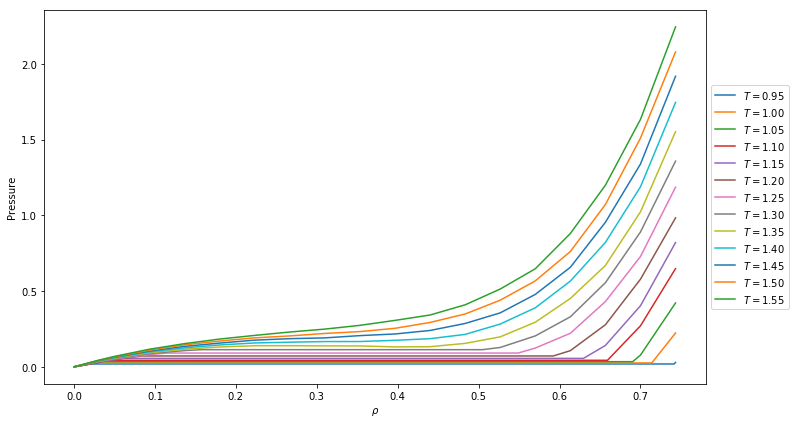

In [31]:
#Plot
f, ax = plt.subplots(1,1,figsize=(10,6))

Y=myds.copy()

for i in range(3,16):
    T=myds[0, i]['TEMPERATURE']
    if T>1.31:
        ax.plot(myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'], 
                            label= r'$T=$%.2f' % T)
    else:   
        P0,Vl,Vr, dP0, dVl, dVr =maxwell_construction(myds[:, i]['PRESSURE'][2:], 1/myds[:, i]['DENSITY'][2:],
                                              T, Perr=myds[:, i]['PRERR'][2:])
        maskl=np.argwhere((1/myds[:, i]['DENSITY']<Vl))
        maskr=np.argwhere((1/myds[:, i]['DENSITY']>Vr))
        Y['PRESSURE'][((1/myds[:, i]['DENSITY']>Vl)&(1/myds[:, i]['DENSITY']<Vr)),i]=P0
        Vmal = myds[:, i]['DENSITY'][maskl][:,0]
        Pmal =myds[:, i]['PRESSURE'][maskl][:,0]
        Vmar = myds[:, i]['DENSITY'][maskr][:,0]
        Pmar =myds[:, i]['PRESSURE'][maskr][:,0]

        Varr=np.concatenate((Vmar,[1/Vr, 1/Vl], Vmal))
        Parr=np.concatenate((Pmar,[P0, P0], Pmal))
        ax.plot(Varr, Parr, label= r'$T=$%.2f' % T)
    

ax.legend()
#ax.set_xlim(xmin=1.2, xmax=4)
#ax.set_ylim(ymax=1.1)
ax.set_xlabel(r"$\rho$")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("Pressure")

plt.tight_layout()

plt.show()

In [32]:
jtab=np.loadtxt('./JohnsonData.txt', unpack=True)

<IPython.core.display.Javascript object>


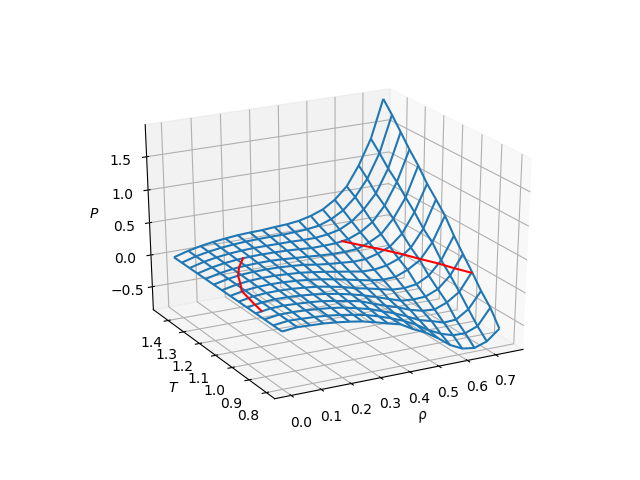

In [45]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mask=[0]+[i for i in range(2,19)]
x, y, z = myds[mask, :14]['DENSITY'],myds[mask, :14]['TEMPERATURE'], myds[mask, :14]['PRESSURE']
#x, y, z =Y[mask,3:12]['DENSITY'],Y[mask,3:12]['TEMPERATURE'], Y[mask,3:12]['PRESSURE']


ps=phasesep[[3,4,5,6,7,8,9,10]]

# Plot a basic wireframe.
ax.plot_wireframe(x,y,z)
ax.plot(ps[:,2], ps[:,0], ps[:,1], color='red')
ax.plot(ps[:,3], ps[:,0], ps[:,1], color='red')
#ax.plot(jtab[1], jtab[0], jtab[3], color='green')
#ax.plot(jtab[2], jtab[0], jtab[3], color='green')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$T$')
ax.set_zlabel(r'$P$')

plt.show()

<IPython.core.display.Javascript object>


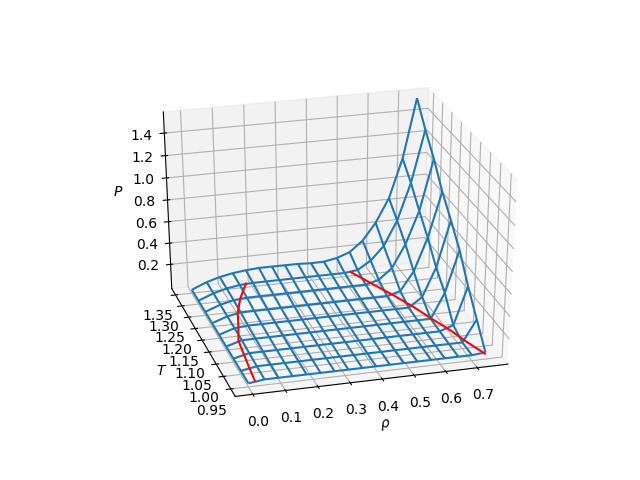

In [44]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mask=[0]+[i for i in range(2,19)]
#x, y, z = myds[mask, :14]['DENSITY'],myds[mask, :14]['TEMPERATURE'], myds[mask, :14]['PRESSURE']
x, y, z =Y[mask,3:12]['DENSITY'],Y[mask,3:12]['TEMPERATURE'], Y[mask,3:12]['PRESSURE']


ps=phasesep[[3,4,5,6,7,8,9,10]]

# Plot a basic wireframe.
ax.plot_wireframe(x,y,z)
ax.plot(ps[:,2], ps[:,0], ps[:,1], color='red')
ax.plot(ps[:,3], ps[:,0], ps[:,1], color='red')
#ax.plot(jtab[1], jtab[0], jtab[3], color='green')
#ax.plot(jtab[2], jtab[0], jtab[3], color='green')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$T$')
ax.set_zlabel(r'$P$')

plt.show()

In [46]:
%matplotlib inline

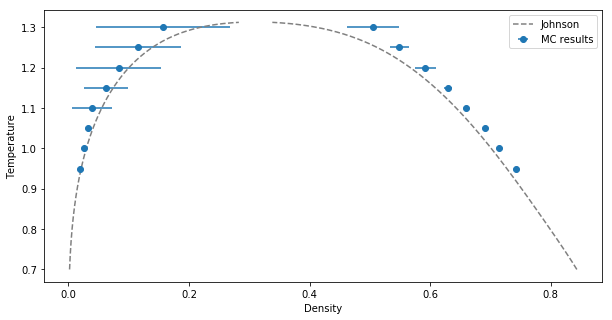

In [57]:
fpd, axarrpd = plt.subplots(1,1,figsize=(10,5))

ps=phasesep[[3,4,5,6,7,8,9,10]]

axarrpd.plot(jtab[1], jtab[0], linestyle='dashed', color='grey', label='Johnson')
axarrpd.errorbar(ps[:,2], ps[:,0], xerr=ps[:,5], marker='o', linestyle='', color='C0', label='MC results')
axarrpd.plot(jtab[2], jtab[0], linestyle='dashed', color='grey')
axarrpd.errorbar(ps[:,3], ps[:,0], xerr=ps[:,6], marker='o', linestyle='', color='C0')

axarrpd.set_ylabel('Temperature')
axarrpd.set_xlabel('Density')
axarrpd.legend()

plt.show()

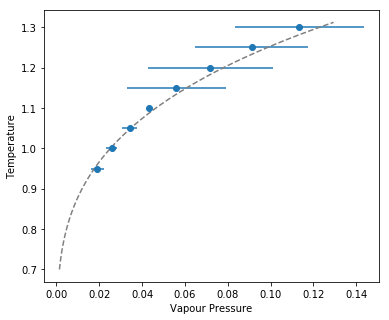

In [55]:
fpd, axarrpd = plt.subplots(1,1,figsize=(6,5))

ps=phasesep[[3,4,5,6,7,8,9,10]]

axarrpd.plot(jtab[3], jtab[0], linestyle='dashed', color='grey')
axarrpd.errorbar(ps[:,1], ps[:,0], xerr=ps[:,4], marker='o', linestyle='', color='C0')

axarrpd.set_ylabel('Temperature')
axarrpd.set_xlabel('Vapour Pressure')

plt.show()

Johnson, J. Karl, John A. Zollweg, and Keith E. Gubbins. "The Lennard-Jones equation of state revisited." *Molecular Physics* 78.3 (1993): 591-618.

In [37]:
seconds=22*tottime/3600000 #total seconds needed
hours=seconds/3600
print("Getting this result for the phase diagram required a total time of %.2f hours of simulation." %hours)

Getting this result for the phase diagram required a total time of 3.80 hours of simulation.


## Size scaling

In [38]:
# counter=0

# rho=0.5
# beta=0.5


# for N1 in range(5,15):
#     L1= rho**(-1/3)*N1
#     delta = deltaf(rho,1/beta)
#     file = open('./data/size_scaling/test%04d.in' % counter,'w') 
#     file.write("N1      %d\nL       %.8f\nDELTAIN %.4f\nBETA    %.8f\nMCTIME  3600000\
#     \nBTIME   10000\nTHBIN   50\n" % (N1, L1, delta, beta))
#     file.close()
#     counter+=1

In [39]:
# dataset=np.empty(0, dtype=dt)

# for file in np.sort(glob.glob('./data/size_scaling/*.out')):
#     d=get_mcdata(file)
#     dataset=np.append(dataset, d)

In [40]:
# # write dataset to file

# fileres = open('./data/size_scaling/res.dat','w') 
# fileres.write('# ')
# for name in dt.names: fileres.write(name+' ') 
# fileres.write('\n')
# for index, i in enumerate(dataset):
#     for j in i:
#         fileres.write(str(j)+' ')
#     fileres.write('\n')   
# fileres.close()

In [41]:
# read dataset from file
ds=np.genfromtxt('./data/size_scaling/res.dat', dtype=dt, names=True)
print(ds['SIMTIME'])
Nds=ds.view().reshape((5,10))

[  22.   38.   59.   82.  117.  165.  206.  263.  332.  399.   21.   35.
   56.   88.  123.  176.  196.  251.  313.  387.   21.   38.   59.   83.
  113.  157.  268.  287.  317.  383.   20.   35.   56.   83.  117.  157.
  200.  255.  318.  385.   21.   35.   56.   84.  116.  157.  201.  256.
  317.  390.]


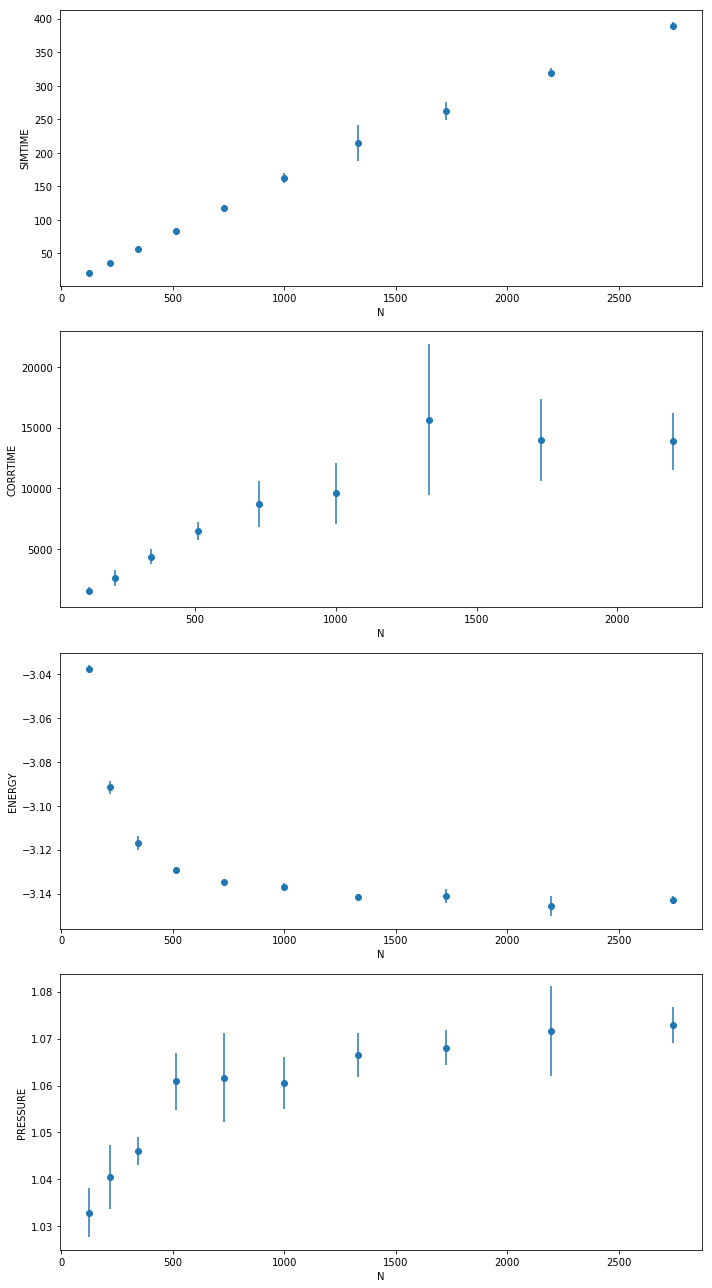

In [42]:
names=['SIMTIME', 'CORRTIME', 'ENERGY', 'PRESSURE']

f, axarr = plt.subplots(len(names),1,figsize=(10,18))

for i, name in enumerate(names):
    axarr[i].errorbar(Nds[0, :]['N'], np.mean(Nds[name], axis=0), 
                      yerr=np.std(Nds[name], axis=0), marker='o', linestyle='')
    axarr[i].set_xlabel('N')
    axarr[i].set_ylabel(name)
plt.tight_layout()

plt.show()